<a href="https://colab.research.google.com/github/mukulre/Projects/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np

In [ ]:
from fastai.vision.all import * # or from fastai.vision import * if using an older version of fastai

x  = r'/content/drive/MyDrive/Pneumonia Detection'
path = Path(x) # Convert the string path to a Path object
path.ls()

(#1) [Path('/content/drive/MyDrive/Pneumonia Detection/chest_xray')]

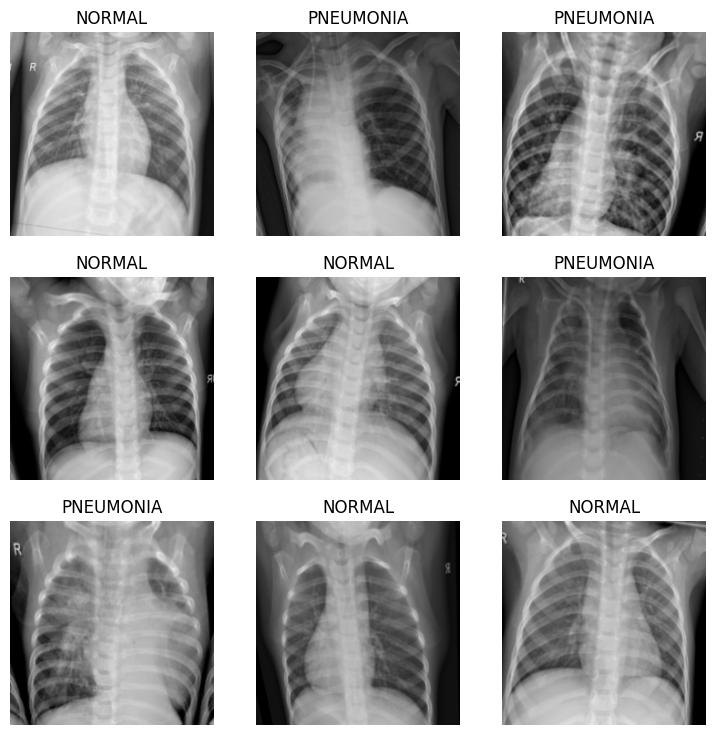

In [ ]:
np.random.seed(40)
data = ImageDataLoaders.from_folder(path, train = '.', valid_pct=0.2,
                                  item_tfms=Resize(224, method='squish'),batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                                  num_workers=4)
data.show_batch()

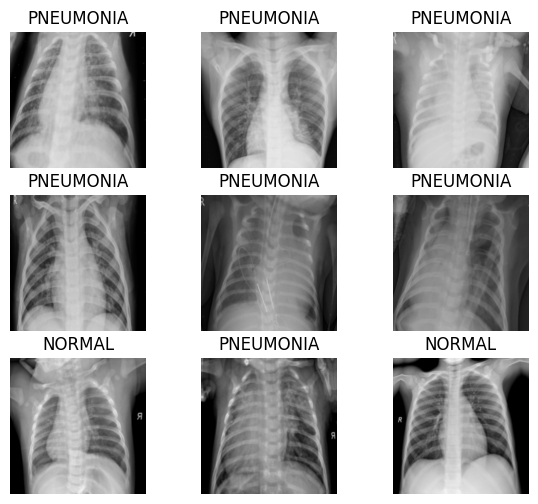

In [ ]:
data.show_batch(nrows=3,max_n=9, figsize=(7,6))

In [ ]:
from fastai.vision.all import *
learn = vision_learner(data, models.resnet50, metrics=[accuracy], model_dir = Path('Path'),path = Path("."))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 150MB/s]


/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

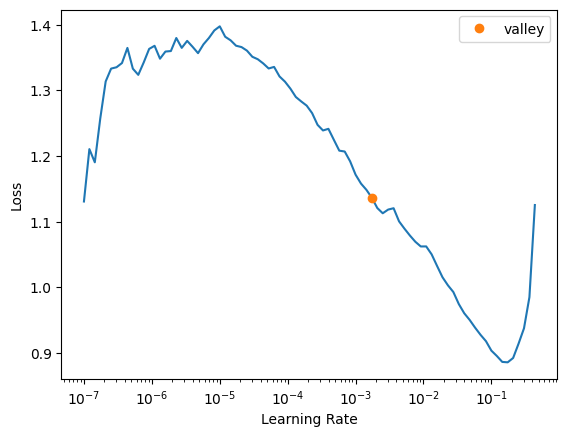

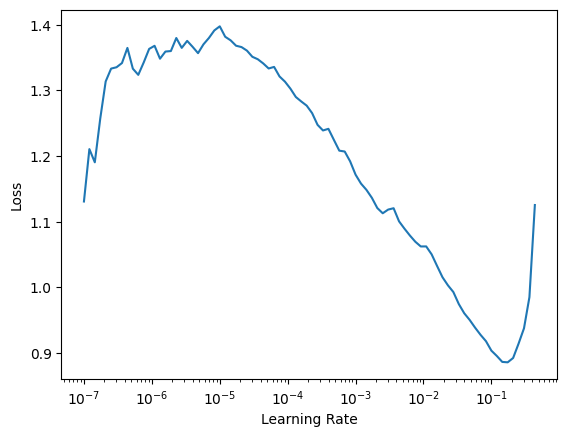

In [ ]:
learn.lr_find()
learn.recorder.plot_lr_find()

In [ ]:
# Use a smaller model (resnet34 instead of resnet50)
learn = vision_learner(data, resnet34, metrics=accuracy)

# Enable mixed precision training for faster computation
learn = learn.to_fp16()

# Simplified learning rate schedule
lr = 1e-2  # Single learning rate instead of slice

# Reduced epochs (4 → 2, 20 → 5, 10 → 3)
learn.fit_one_cycle(2, lr)  # Initial training

learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-2))  # Fine-tuning

# Optional: Remove plotting to save time
# learn.recorder.plot_losses()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 164MB/s]
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,accuracy,time
0,0.312860,0.157468,0.947137,04:48
1,0.145922,0.082316,0.977344,03:14


epoch,train_loss,valid_loss,accuracy,time
0,0.172624,0.413784,0.927627,03:12
1,0.134316,0.105557,0.967904,03:15
2,0.086397,0.058187,0.979232,03:14


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Subfolders found: ['chest_xray']
Total image files found: 7946
DataLoaders created. Classes: ['NORMAL', 'PNEUMONIA'], Total items: 6357


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 146MB/s]


epoch,train_loss,valid_loss,accuracy,time
0,0.386871,0.390357,0.870988,31:40
1,0.259956,0.166164,0.931403,04:34
2,0.193936,0.207865,0.926369,04:28
3,0.167911,0.157313,0.932662,04:29
4,0.107381,0.142623,0.944619,04:31


Prediction for person1947_bacteria_4876.jpeg: PNEUMONIA


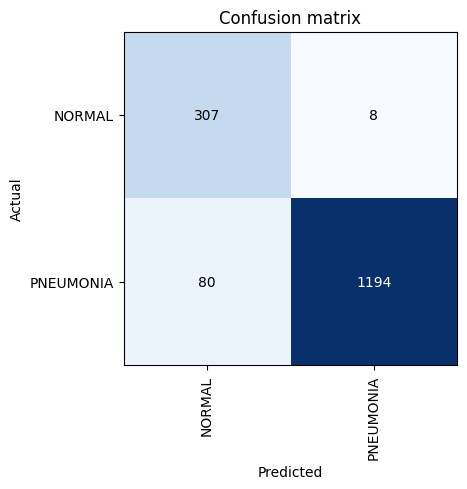

In [6]:
# Install FastAI if needed
!pip install -Uqq fastai

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

from fastai.vision.all import *
from fastai.vision.core import PILImage

# Specify your dataset path
path = Path('/content/drive/MyDrive/Pneumonia Detection')

# Verify the path exists
if not path.exists():
    print(f"Dataset path {path} not found. Check Drive mounting or folder name.")
    raise FileNotFoundError(f"Directory {path} does not exist.")

# Check subfolders and files (debugging)
subfolders = [f.name for f in path.ls() if f.is_dir()]
print(f"Subfolders found: {subfolders}")
image_files = get_image_files(path)
print(f"Total image files found: {len(image_files)}")
if len(image_files) == 0:
    print("No images found. Verify folder structure (subfolders with images expected).")
    raise ValueError("No image files detected.")

# Define DataBlock and create DataLoaders directly
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,  # Gets all image files in subfolders
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # 20% validation split
    get_y=parent_label,  # Labels from subfolder names
    item_tfms=[Resize(192), ToTensor()],  # Convert PILImage to tensor
    batch_tfms=aug_transforms(size=224, min_scale=0.75)  # Augmentations
).dataloaders(path, bs=8, num_workers=0)  # Create DataLoaders directly

print(f"DataLoaders created. Classes: {dls.vocab}, Total items: {len(dls.dataset)}")

# Initialize and train the model
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fit_one_cycle(5)

# Plot confusion matrix if training succeeded
if learn.validate()[1] is not None:
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix()
else:
    print("Model training failed, cannot plot confusion matrix.")

# Test prediction with an image from your dataset
img_path = get_image_files(path)[0]  # First image from your dataset
img = PILImage.create(img_path)
pred = learn.predict(img)[0]
print(f"Prediction for {img_path.name}: {pred}")

# Test your specific image (uncomment after uploading to Colab)
# try:
#     img = PILImage.create('/content/IM-0001-0001.jpeg')  # Adjust path if needed
#     pred = learn.predict(img)[0]
#     print(pred)
# except FileNotFoundError:
#     print("Image file not found. Please upload 'IM-0001-0001.jpeg' to Colab.")